In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from keras.models import Sequential
from keras.layers import Dense, Dropout

def readin():
    stat_file = open('./new/conference_stat.csv','r')
    next(stat_file, None)    #remove header
    stat=[]
    for line in stat_file:
        line = line.strip().split(",")[1:43]+line.strip().split(",")[-1:-25:-1]
        line = np.array(list(map(float,line)))    #only take the score part
        stat.append(line)    

    result_file = open('./new/conference_res.csv','r')
    next(result_file, None)     #remove header
    
    results=[]
    
    for line in result_file:     
        line = line.strip().split(",")
        line = line[-1:-3:-1]    #only take the score part
        line.reverse()
        line = np.array(list(map(float,line)))    #only take the score part
        results.append(line)

    stat, results = np.array(stat),np.array(results)
    
    #normalization
    stat = (stat-stat.min(axis=0))/(stat.max(axis=0)-stat.min(axis=0))-0.5
    #red_results = (red_results-red_results.min(axis=0))/(red_results.max(axis=0)-red_results.min(axis=0))-0.5

    X_train, X_test, Y_train, Y_test= stat[:-5],stat[-5:],results[:-5],results[-5:]
    return  X_train, X_test, Y_train, Y_test

class Network():

    def __init__(self, nn_param_choices):        
        self.accuracy = 0.
        self.nn_param_choices = nn_param_choices
        self.network = {}  # (dic): represents MLP network parameters

    def create_random(self):
        for key in self.nn_param_choices:
            self.network[key] = random.choice(self.nn_param_choices[key])

    def create_set(self, network):
        self.network = network
        
    def compile_model(self,nb_classes,input_shape):       
        nb_layers = self.network['nb_layers']
        nb_neurons = self.network['nb_neurons']
        activation = self.network['activation']
        optimizer = self.network['optimizer']
        model = Sequential()
        for i in range(nb_layers):
            if i == 0:
                model.add(Dense(nb_neurons, activation=activation, input_shape=(input_shape,)))
        else:
                model.add(Dense(nb_neurons, activation=activation))
        model.add(Dropout(0.2))  # hard-coded dropout
        #model.add(Dense(nb_classes, activation='softmax'))
        model.add(Dense(nb_classes))
        
        model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['accuracy'])
        
        return model
    
    def train_score(self, x_train, y_train, x_test, y_test):        
        nb_classes = y_train.shape[1]
        input_shape = x_train.shape[1]
        model = self.compile_model(nb_classes,input_shape)
        model.fit(x_train, y_train,epochs=20,verbose=0)
        pred_train = model.predict(x_train)
        pred = model.predict(x_test)
            
        win_acc = 0.0
        score_diff = 0.0
        score_diff_sum = 0.0
        std = 0.0
        std_sum = 0.0
        spread_diff = 0.0
        
        for i in range(x_train.shape[0]):
            if (pred_train[i][0]-pred_train[i][1])*(y_train[i][0]-y_train[i][1])>0:
                win_acc+=1.0
            score_diff += 0.5*(abs(pred_train[i][0] - y_train[i][0]) + abs(pred_train[i][1] - y_train[i][1]))
            std += 0.5*(pred_train[i][0] - y_train[i][0])**2 + (pred_train[i][1] - y_train[i][1])**2
            
            score_diff_sum += abs(pred_train[i][0] - y_train[i][0] + pred_train[i][1] - y_train[i][1])
            std_sum += (pred_train[i][0] - y_train[i][0] + pred_train[i][1] - y_train[i][1])**2
            spread_diff += abs((pred_train[i][0]-pred_train[i][1])-(y_train[i][0]-y_train[i][1]))
            
            
        win_acc/=x_train.shape[0]
        score_diff /= x_train.shape[0]
        std /= x_train.shape[0]
        std = std**0.5
        
        score_diff_sum /= x_train.shape[0]
        std_sum /= x_train.shape[0]
        std_sum = std_sum**0.5
        spread_diff /= x_train.shape[0]
        
        
        print("win_acc = "+str(win_acc))
        print("score_diff = "+str(score_diff))
        print("std = "+str(std))
        print("score_diff_sum = " +str(score_diff_sum))
        print("std_sum = "+str(std_sum))
        print("spread_diff "+str(spread_diff))

        # define accuracy score (fitness score)
        score = 0
        
        for i in range(x_test.shape[0]):
            
            print("predicted: "+str(pred[i][0])+" vs "+str(pred[i][1]))
            print("actual: "+str(y_test[i][0])+" vs "+str(y_test[i][1]))
            pred_diff = (pred[i][0]-pred[i][1])/(pred[i][0]+pred[i][1])
            
            if(y_test[i][0]-y_test[i][1])==0:
                score += 1-abs(pred_diff)             
            else:    
                test_diff = (y_test[i][0]-y_test[i][1])/(y_test[i][0]+y_test[i][1])
                score += pred_diff/test_diff 
            
        
       
        print(self.network)
        #score =score/x_test.shape[0]
        #score = -score_diff
        print("score = "+str(score))
        self.accuracy = score
            
        
        
        print()
            
 

/Users/jinchi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def create_population(count, nn_param_choices):
    pop = []
    for _ in range(0, count):
        network = Network(nn_param_choices)
        network.create_random()
        pop.append(network)
    return pop

def breed(nn_param_choices,mother,father,mutate_chance=0.2):
    children = []
    for _ in range(2): # two children
        child = {}
            # Loop through the parameters and pick params for the kid.
        for param in nn_param_choices:
            child[param] = random.choice([mother.network[param], father.network[param]])
            
        network = Network(nn_param_choices)
        network.create_set(child)

        if mutate_chance > random.random():
            network = mutate(nn_param_choices,network)

        children.append(network)

    return children

def mutate(nn_param_choices, network):
    mutation = random.choice(list(nn_param_choices.keys()))
    network.network[mutation] = random.choice(nn_param_choices[mutation])
    return network

def evolve(pop,nn_param_choices,retain=0.5,random_select_rate=0.1):
    graded = pop
        # Get the number we want to keep for the next gen.
    retain_length = int(len(graded)*retain)
        # The parents are every network we want to keep.
    parents = graded[:retain_length]
        # For those we aren't keeping, randomly keep some anyway.
    for individual in graded[retain_length:]:
        if random_select_rate > random.random():
            parents.append(individual)

        # Now find out how many spots we have left to fill.
    parents_length = len(parents)
    desired_length = len(pop) - parents_length
    children = []

        # Add children, which are bred from two remaining networks.
    while len(children) < desired_length:
            # Get a random mom and dad.
        male = random.randint(0, parents_length-1)
        female = random.randint(0, parents_length-1)

            # Assuming they aren't the same network...
        if male != female:
            male = parents[male]
            female = parents[female]
            babies = breed(nn_param_choices,male, female)
            
            for baby in babies:
                    # Don't grow larger than desired length.
                if len(children) < desired_length:
                    children.append(baby)

    parents.extend(children)
    #for parent in parents:
        #print("parents are:")
        #print(parent.network)

    return parents


In [3]:
def train_networks(networks, x_train, y_train, x_test, y_test):
    for network in networks:
        network.train_score(x_train, y_train, x_test, y_test)
        
def get_average_accuracy(networks):
    total_accuracy = 0
    for network in networks:
        total_accuracy += network.accuracy

    return total_accuracy / len(networks)

def generate(generations, population, nn_param_choices, x_train, y_train, x_test, y_test):
    fitness_history = []
    networks = create_population(population,nn_param_choices)
    # Evolve the generation.
    for i in range(generations):
        print("this is "+str(i)+"th generation:")
        train_networks(networks, x_train, y_train, x_test, y_test)
        average_accuracy = get_average_accuracy(networks)
        print("average_accuracy= "+str(average_accuracy))
        fitness_history.append(average_accuracy)
        if i != generations - 1:
            networks = evolve(networks,nn_param_choices)
            
    networks = sorted(networks, key=lambda x: x.accuracy, reverse=True)
    print("network rank:")
    for individual in networks:
        print(individual.network)
        print(individual.accuracy)
    return  fitness_history 
        


In [4]:
#print(np.array(fitness_history))

this is 0th generation:
Instructions for updating:
keep_dims is deprecated, use keepdims instead
win_acc = 0.7010349541105253
score_diff = 11.045881324623553
std = 16.909293867243164
score_diff_sum = 14.779122945364275
std_sum = 18.886898203523845
spread_diff 15.518314760845403
predicted: 25.192736 vs 28.89359
actual: 24.0 vs 45.0
predicted: 29.372042 vs 27.071947
actual: 35.0 vs 28.0
predicted: 28.726492 vs 28.294752
actual: 3.0 vs 10.0
predicted: 25.1835 vs 29.399519
actual: 39.0 vs 27.0
predicted: 30.542433 vs 24.317894
actual: 42.0 vs 10.0
{'nb_neurons': 32, 'nb_layers': 2, 'activation': 'tanh', 'optimizer': 'adamax'}
score = 0.33706617069297606

win_acc = 0.7139230619019723
score_diff = 10.002774418994939
std = 15.392689244852633
score_diff_sum = 13.941363747802896
std_sum = 17.901510745783934
spread_diff 13.831470793240053
predicted: 21.26083 vs 30.955605
actual: 24.0 vs 45.0
predicted: 28.477045 vs 23.842873
actual: 35.0 vs 28.0
predicted: 40.13803 vs 21.81302
actual: 3.0 vs 10.

win_acc = 0.7090412028900606
score_diff = 10.177832113860804
std = 15.577948044592903
score_diff_sum = 13.967300331608854
std_sum = 17.847150856235466
spread_diff 14.15176733497809
predicted: 24.268278 vs 30.198484
actual: 24.0 vs 45.0
predicted: 29.009 vs 23.428598
actual: 35.0 vs 28.0
predicted: 33.732517 vs 24.636835
actual: 3.0 vs 10.0
predicted: 27.003529 vs 36.76325
actual: 39.0 vs 27.0
predicted: 36.4588 vs 17.670948
actual: 42.0 vs 10.0
{'nb_neurons': 128, 'nb_layers': 4, 'activation': 'sigmoid', 'optimizer': 'adam'}
score = 0.7483475846903664

win_acc = 0.7129466900995899
score_diff = 10.104655086842861
std = 15.507785229915765
score_diff_sum = 13.917649109878942
std_sum = 17.827711625995228
spread_diff 14.059341146852374
predicted: 22.600435 vs 30.16902
actual: 24.0 vs 45.0
predicted: 28.296574 vs 23.60079
actual: 35.0 vs 28.0
predicted: 36.952145 vs 21.888994
actual: 3.0 vs 10.0
predicted: 29.210537 vs 35.58828
actual: 39.0 vs 27.0
predicted: 35.124138 vs 16.978077
actual: 4

win_acc = 0.7147041593438781
score_diff = 10.152257046460221
std = 15.516798452869732
score_diff_sum = 13.984741137936068
std_sum = 17.813527897305814
spread_diff 14.072204393559288
predicted: 22.754856 vs 32.478893
actual: 24.0 vs 45.0
predicted: 31.712215 vs 25.104366
actual: 35.0 vs 28.0
predicted: 38.006332 vs 21.95771
actual: 3.0 vs 10.0
predicted: 32.780148 vs 33.18928
actual: 39.0 vs 27.0
predicted: 36.217495 vs 18.219242
actual: 42.0 vs 10.0
{'nb_neurons': 64, 'nb_layers': 3, 'activation': 'tanh', 'optimizer': 'adam'}
score = 1.6312883912386107

win_acc = 0.48916227299355597
score_diff = 13.131138639742451
std = 20.246871938800286
score_diff_sum = 19.989276281862235
std_sum = 25.25677301647617
spread_diff 17.3397439518284
predicted: 18.949162 vs 21.165966
actual: 24.0 vs 45.0
predicted: 18.949032 vs 21.165829
actual: 35.0 vs 28.0
predicted: 18.950357 vs 21.167246
actual: 3.0 vs 10.0
predicted: 18.951002 vs 21.168045
actual: 39.0 vs 27.0
predicted: 18.950478 vs 21.167381
actual:

win_acc = 0.5098613552040617
score_diff = 12.258469482903088
std = 19.113780628752743
score_diff_sum = 17.23895570613099
std_sum = 22.204297776935732
spread_diff 17.222614277528844
predicted: 23.056988 vs 22.167856
actual: 24.0 vs 45.0
predicted: 23.058014 vs 22.168821
actual: 35.0 vs 28.0
predicted: 23.057648 vs 22.168478
actual: 3.0 vs 10.0
predicted: 23.059998 vs 22.170876
actual: 39.0 vs 27.0
predicted: 23.058832 vs 22.16956
actual: 42.0 vs 10.0
{'nb_neurons': 32, 'nb_layers': 2, 'activation': 'sigmoid', 'optimizer': 'adagrad'}
score = 0.21590243063734046

win_acc = 0.5098613552040617
score_diff = 11.664365533040245
std = 17.732170550680852
score_diff_sum = 14.853341000360848
std_sum = 18.9733600745022
spread_diff 17.228304892958803
predicted: 28.01997 vs 27.425234
actual: 24.0 vs 45.0
predicted: 28.019608 vs 27.424675
actual: 35.0 vs 28.0
predicted: 28.020214 vs 27.425613
actual: 3.0 vs 10.0
predicted: 28.02197 vs 27.427982
actual: 39.0 vs 27.0
predicted: 28.01998 vs 27.424932
act

win_acc = 0.5098613552040617
score_diff = 11.676320919416026
std = 17.718380501134167
score_diff_sum = 14.857877936546656
std_sum = 18.94033080826147
spread_diff 17.230100721475832
predicted: 28.255219 vs 27.74411
actual: 24.0 vs 45.0
predicted: 28.254967 vs 27.743872
actual: 35.0 vs 28.0
predicted: 28.254738 vs 27.743689
actual: 3.0 vs 10.0
predicted: 28.258226 vs 27.746807
actual: 39.0 vs 27.0
predicted: 28.255688 vs 27.744493
actual: 42.0 vs 10.0
{'nb_neurons': 16, 'nb_layers': 2, 'activation': 'sigmoid', 'optimizer': 'adamax'}
score = 0.10026245654028441

average_accuracy= 0.4816127947697947
this is 3th generation:
win_acc = 0.5098613552040617
score_diff = 11.683012580759845
std = 17.71014856924101
score_diff_sum = 14.871921838761493
std_sum = 18.920867093057954
spread_diff 17.225273865318186
predicted: 28.467632 vs 27.98037
actual: 24.0 vs 45.0
predicted: 28.480186 vs 27.985981
actual: 35.0 vs 28.0
predicted: 28.484768 vs 27.991817
actual: 3.0 vs 10.0
predicted: 28.497175 vs 28.00

win_acc = 0.7106033977738723
score_diff = 10.061971094477482
std = 15.435078561006216
score_diff_sum = 13.869819280761826
std_sum = 17.734229542739353
spread_diff 14.021419537996227
predicted: 23.032745 vs 29.525675
actual: 24.0 vs 45.0
predicted: 29.096767 vs 23.916975
actual: 35.0 vs 28.0
predicted: 35.816624 vs 24.163378
actual: 3.0 vs 10.0
predicted: 27.91615 vs 37.800236
actual: 39.0 vs 27.0
predicted: 36.51713 vs 15.489211
actual: 42.0 vs 10.0
{'nb_neurons': 32, 'nb_layers': 2, 'activation': 'relu', 'optimizer': 'adam'}
score = 0.7542656612183367

win_acc = 0.7106033977738723
score_diff = 10.1441018807192
std = 15.509813030886082
score_diff_sum = 13.873456755691942
std_sum = 17.713002835646172
spread_diff 14.18214684691054
predicted: 24.353075 vs 30.432875
actual: 24.0 vs 45.0
predicted: 30.061096 vs 24.74713
actual: 35.0 vs 28.0
predicted: 33.046566 vs 27.84329
actual: 3.0 vs 10.0
predicted: 26.836979 vs 40.464153
actual: 39.0 vs 27.0
predicted: 37.075756 vs 17.780798
actual: 42

win_acc = 0.7119703182972076
score_diff = 10.168001201091812
std = 15.483154884265486
score_diff_sum = 13.994399153052585
std_sum = 17.787206535681143
spread_diff 14.068927259841857
predicted: 23.42576 vs 31.350798
actual: 24.0 vs 45.0
predicted: 31.21734 vs 25.75059
actual: 35.0 vs 28.0
predicted: 38.614857 vs 21.808748
actual: 3.0 vs 10.0
predicted: 33.010452 vs 33.52103
actual: 39.0 vs 27.0
predicted: 36.94001 vs 17.930578
actual: 42.0 vs 10.0
{'nb_neurons': 64, 'nb_layers': 3, 'activation': 'tanh', 'optimizer': 'adam'}
score = 1.3432486030339663

win_acc = 0.7027924233548135
score_diff = 10.420003970603743
std = 15.872231119689248
score_diff_sum = 14.200999876736338
std_sum = 18.06478333313648
spread_diff 14.553681403020239
predicted: 24.184269 vs 32.250942
actual: 24.0 vs 45.0
predicted: 31.15657 vs 26.432487
actual: 35.0 vs 28.0
predicted: 33.08683 vs 28.210155
actual: 3.0 vs 10.0
predicted: 25.007046 vs 36.05023
actual: 39.0 vs 27.0
predicted: 34.050205 vs 20.37024
actual: 42.0 

win_acc = 0.48916227299355597
score_diff = 11.931841187122346
std = 18.45077170986727
score_diff_sum = 16.10709961688372
std_sum = 20.820305858109958
spread_diff 17.245723377235976
predicted: 23.939941 vs 24.217627
actual: 24.0 vs 45.0
predicted: 23.941193 vs 24.218517
actual: 35.0 vs 28.0
predicted: 23.941496 vs 24.218752
actual: 3.0 vs 10.0
predicted: 23.94089 vs 24.222338
actual: 39.0 vs 27.0
predicted: 23.9422 vs 24.218967
actual: 42.0 vs 10.0
{'nb_neurons': 32, 'nb_layers': 2, 'activation': 'sigmoid', 'optimizer': 'adagrad'}
score = -0.0636668304214254

win_acc = 0.48916227299355597
score_diff = 11.668887079332379
std = 17.73450327564843
score_diff_sum = 14.851837897156393
std_sum = 18.98763491578847
spread_diff 17.24093547553621
predicted: 27.598186 vs 27.66513
actual: 24.0 vs 45.0
predicted: 27.598972 vs 27.665041
actual: 35.0 vs 28.0
predicted: 27.598488 vs 27.665207
actual: 3.0 vs 10.0
predicted: 27.599918 vs 27.667107
actual: 39.0 vs 27.0
predicted: 27.600391 vs 27.664919
act

win_acc = 0.7129466900995899
score_diff = 9.993399851630848
std = 15.320818466120212
score_diff_sum = 13.877260530863254
std_sum = 17.691928443698703
spread_diff 13.828444196153166
predicted: 21.791365 vs 31.139603
actual: 24.0 vs 45.0
predicted: 30.463638 vs 26.310936
actual: 35.0 vs 28.0
predicted: 39.24611 vs 21.740662
actual: 3.0 vs 10.0
predicted: 29.73377 vs 32.562443
actual: 39.0 vs 27.0
predicted: 38.04085 vs 18.896542
actual: 42.0 vs 10.0
{'nb_neurons': 32, 'nb_layers': 1, 'activation': 'relu', 'optimizer': 'nadam'}
score = 1.002164529104318

average_accuracy= 0.48578078140625225
this is 6th generation:
win_acc = 0.5420816246826792
score_diff = 11.62727637757456
std = 17.69826243292379
score_diff_sum = 14.813854543801002
std_sum = 18.8659239496193
spread_diff 17.144564782984204
predicted: 27.89477 vs 27.652538
actual: 24.0 vs 45.0
predicted: 28.352207 vs 27.906517
actual: 35.0 vs 28.0
predicted: 28.264853 vs 27.866219
actual: 3.0 vs 10.0
predicted: 28.387001 vs 27.945896
actua

win_acc = 0.7035735207967194
score_diff = 11.190727218057326
std = 17.108825452129576
score_diff_sum = 14.764955182439577
std_sum = 18.876059599393336
spread_diff 15.924949593479758
predicted: 26.12922 vs 28.30615
actual: 24.0 vs 45.0
predicted: 28.730772 vs 26.37495
actual: 35.0 vs 28.0
predicted: 27.6696 vs 27.841259
actual: 3.0 vs 10.0
predicted: 25.32542 vs 28.948374
actual: 39.0 vs 27.0
predicted: 29.788761 vs 25.611343
actual: 42.0 vs 10.0
{'nb_neurons': 64, 'nb_layers': 2, 'activation': 'sigmoid', 'optimizer': 'adam'}
score = 0.27729018375144476

win_acc = 0.6969341925405195
score_diff = 10.360986989123168
std = 15.806746839522464
score_diff_sum = 14.28040761115192
std_sum = 18.191381827579065
spread_diff 14.368999727208548
predicted: 25.420511 vs 31.682476
actual: 24.0 vs 45.0
predicted: 31.365982 vs 25.914606
actual: 35.0 vs 28.0
predicted: 31.559372 vs 32.34584
actual: 3.0 vs 10.0
predicted: 26.414818 vs 40.386467
actual: 39.0 vs 27.0
predicted: 35.939747 vs 19.777473
actual:

win_acc = 0.7164616285881664
score_diff = 10.131422301890025
std = 15.51687020711087
score_diff_sum = 13.95054923461485
std_sum = 17.82876358192717
spread_diff 14.091372263103322
predicted: 21.83926 vs 32.01573
actual: 24.0 vs 45.0
predicted: 30.421768 vs 24.75879
actual: 35.0 vs 28.0
predicted: 37.8336 vs 22.970142
actual: 3.0 vs 10.0
predicted: 31.162922 vs 34.643475
actual: 39.0 vs 27.0
predicted: 35.455086 vs 18.211134
actual: 42.0 vs 10.0
{'nb_neurons': 64, 'nb_layers': 3, 'activation': 'tanh', 'optimizer': 'adam'}
score = 1.3217728672815219

win_acc = 0.7148994337043546
score_diff = 9.998739145156392
std = 15.321213849247446
score_diff_sum = 13.825346088018344
std_sum = 17.651910432944618
spread_diff 13.838816599183845
predicted: 22.060587 vs 31.102325
actual: 24.0 vs 45.0
predicted: 29.28631 vs 24.273306
actual: 35.0 vs 28.0
predicted: 39.6437 vs 21.962341
actual: 3.0 vs 10.0
predicted: 33.012882 vs 34.64061
actual: 39.0 vs 27.0
predicted: 36.892517 vs 16.838863
actual: 42.0 vs 

win_acc = 0.5098613552040617
score_diff = 12.13748127993744
std = 18.87441848283581
score_diff_sum = 16.840429088515805
std_sum = 21.714765771508777
spread_diff 17.22931776212496
predicted: 23.369461 vs 22.820478
actual: 24.0 vs 45.0
predicted: 23.37049 vs 22.821512
actual: 35.0 vs 28.0
predicted: 23.370209 vs 22.821278
actual: 3.0 vs 10.0
predicted: 23.372147 vs 22.823336
actual: 39.0 vs 27.0
predicted: 23.37117 vs 22.822142
actual: 42.0 vs 10.0
{'nb_neurons': 32, 'nb_layers': 2, 'activation': 'sigmoid', 'optimizer': 'adagrad'}
score = 0.1304952234994354

win_acc = 0.5098613552040617
score_diff = 11.66764061545469
std = 17.72548116612929
score_diff_sum = 14.855029365183482
std_sum = 18.959435706882473
spread_diff 17.23123930730151
predicted: 28.050507 vs 27.598188
actual: 24.0 vs 45.0
predicted: 28.050098 vs 27.597748
actual: 35.0 vs 28.0
predicted: 28.050282 vs 27.597994
actual: 3.0 vs 10.0
predicted: 28.051981 vs 27.599777
actual: 39.0 vs 27.0
predicted: 28.050173 vs 27.597788
actua

win_acc = 0.702597148994337
score_diff = 10.222346916861703
std = 15.653293553953564
score_diff_sum = 14.08183169760664
std_sum = 17.959648740887978
spread_diff 14.229527587607558
predicted: 23.631697 vs 30.96217
actual: 24.0 vs 45.0
predicted: 30.95101 vs 25.988577
actual: 35.0 vs 28.0
predicted: 35.29619 vs 31.73179
actual: 3.0 vs 10.0
predicted: 28.048306 vs 40.98351
actual: 39.0 vs 27.0
predicted: 37.24427 vs 18.218151
actual: 42.0 vs 10.0
{'nb_neurons': 32, 'nb_layers': 2, 'activation': 'elu', 'optimizer': 'adamax'}
score = 0.6536536317850863

average_accuracy= 0.6534126149881299
this is 9th generation:
win_acc = 0.5483304042179262
score_diff = 11.577095283891186
std = 17.576712971769567
score_diff_sum = 14.842305099794208
std_sum = 18.97451186193627
spread_diff 16.98523252770622
predicted: 28.039856 vs 27.567467
actual: 24.0 vs 45.0
predicted: 27.982351 vs 26.87571
actual: 35.0 vs 28.0
predicted: 28.14767 vs 27.37964
actual: 3.0 vs 10.0
predicted: 28.22937 vs 27.938053
actual: 39

win_acc = 0.718414372192931
score_diff = 9.982048280535674
std = 15.382838163533773
score_diff_sum = 13.875415937855383
std_sum = 17.800626097082425
spread_diff 13.793847541421728
predicted: 21.007103 vs 30.406866
actual: 24.0 vs 45.0
predicted: 28.948725 vs 24.46959
actual: 35.0 vs 28.0
predicted: 39.905834 vs 19.939678
actual: 3.0 vs 10.0
predicted: 32.46171 vs 32.9024
actual: 39.0 vs 27.0
predicted: 36.67429 vs 16.729239
actual: 42.0 vs 10.0
{'nb_neurons': 32, 'nb_layers': 2, 'activation': 'elu', 'optimizer': 'nadam'}
score = 1.305587934529675

win_acc = 0.7168521773091193
score_diff = 10.043331112346712
std = 15.313518075427192
score_diff_sum = 13.965030229177774
std_sum = 17.713861468681916
spread_diff 13.832003352465609
predicted: 23.620424 vs 33.260887
actual: 24.0 vs 45.0
predicted: 31.247126 vs 26.144716
actual: 35.0 vs 28.0
predicted: 41.496468 vs 23.250607
actual: 3.0 vs 10.0
predicted: 33.215347 vs 37.12729
actual: 39.0 vs 27.0
predicted: 38.313908 vs 17.03162
actual: 42.0 

win_acc = 0.7135325131810193
score_diff = 10.143344429874997
std = 15.49448823012758
score_diff_sum = 13.951871609180333
std_sum = 17.785459790833766
spread_diff 14.099012943246219
predicted: 21.774464 vs 32.861267
actual: 24.0 vs 45.0
predicted: 30.40002 vs 25.75493
actual: 35.0 vs 28.0
predicted: 38.31007 vs 23.96581
actual: 3.0 vs 10.0
predicted: 30.684406 vs 35.81571
actual: 39.0 vs 27.0
predicted: 35.586723 vs 18.199358
actual: 42.0 vs 10.0
{'nb_neurons': 64, 'nb_layers': 3, 'activation': 'tanh', 'optimizer': 'adam'}
score = 1.0843726662652833

win_acc = 0.6940050771333723
score_diff = 10.411214874117105
std = 15.970135589181519
score_diff_sum = 14.326141429678394
std_sum = 18.343317300574263
spread_diff 14.445068591415266
predicted: 23.822544 vs 29.568892
actual: 24.0 vs 45.0
predicted: 29.737099 vs 26.474108
actual: 35.0 vs 28.0
predicted: 30.50573 vs 30.831879
actual: 3.0 vs 10.0
predicted: 28.459965 vs 37.874638
actual: 39.0 vs 27.0
predicted: 35.19348 vs 19.367922
actual: 42.

win_acc = 0.5098613552040617
score_diff = 11.736878443127427
std = 17.97478457894461
score_diff_sum = 15.176259858187835
std_sum = 19.567367006563728
spread_diff 17.227720399173855
predicted: 26.242056 vs 25.618351
actual: 24.0 vs 45.0
predicted: 26.24332 vs 25.619547
actual: 35.0 vs 28.0
predicted: 26.243412 vs 25.619778
actual: 3.0 vs 10.0
predicted: 26.247097 vs 25.62408
actual: 39.0 vs 27.0
predicted: 26.24395 vs 25.619907
actual: 42.0 vs 10.0
{'nb_neurons': 32, 'nb_layers': 2, 'activation': 'sigmoid', 'optimizer': 'adagrad'}
score = 0.13201098727794097

win_acc = 0.5098613552040617
score_diff = 11.667466093054788
std = 17.72533658677434
score_diff_sum = 14.855126911856845
std_sum = 18.95926418258483
spread_diff 17.23174928524745
predicted: 28.038883 vs 27.613213
actual: 24.0 vs 45.0
predicted: 28.038845 vs 27.613102
actual: 35.0 vs 28.0
predicted: 28.03848 vs 27.612835
actual: 3.0 vs 10.0
predicted: 28.040102 vs 27.614357
actual: 39.0 vs 27.0
predicted: 28.039543 vs 27.613663
actu

win_acc = 0.5098613552040617
score_diff = 11.67130816604355
std = 17.721922516899276
score_diff_sum = 14.85675298634555
std_sum = 18.95019095988024
spread_diff 17.231446692450533
predicted: 28.125158 vs 27.682493
actual: 24.0 vs 45.0
predicted: 28.125816 vs 27.683138
actual: 35.0 vs 28.0
predicted: 28.12652 vs 27.683834
actual: 3.0 vs 10.0
predicted: 28.127562 vs 27.68487
actual: 39.0 vs 27.0
predicted: 28.126371 vs 27.683668
actual: 42.0 vs 10.0
{'nb_neurons': 16, 'nb_layers': 3, 'activation': 'sigmoid', 'optimizer': 'adam'}
score = 0.08711008915478097

average_accuracy= 0.5518925580669019
this is 12th generation:
win_acc = 0.7045498925991017
score_diff = 10.949365668361063
std = 16.812600626687384
score_diff_sum = 14.798202748550985
std_sum = 18.855727072632902
spread_diff 15.232580790922897
predicted: 24.246727 vs 28.957684
actual: 24.0 vs 45.0
predicted: 29.313774 vs 26.856207
actual: 35.0 vs 28.0
predicted: 30.619194 vs 27.50691
actual: 3.0 vs 10.0
predicted: 23.692225 vs 29.58504

win_acc = 0.7131419644600664
score_diff = 10.14062903779858
std = 15.498362691262804
score_diff_sum = 13.900079096231906
std_sum = 17.752441989806577
spread_diff 14.142764772528015
predicted: 23.126905 vs 30.47042
actual: 24.0 vs 45.0
predicted: 29.14224 vs 24.287569
actual: 35.0 vs 28.0
predicted: 35.65276 vs 22.733984
actual: 3.0 vs 10.0
predicted: 27.92489 vs 37.779964
actual: 39.0 vs 27.0
predicted: 35.002007 vs 17.270618
actual: 42.0 vs 10.0
{'nb_neurons': 64, 'nb_layers': 2, 'activation': 'sigmoid', 'optimizer': 'nadam'}
score = 0.5832865935351166

win_acc = 0.7018160515524312
score_diff = 10.631509154784775
std = 16.194969995080285
score_diff_sum = 14.527680448991344
std_sum = 18.559335139232463
spread_diff 14.749120093630385
predicted: 24.02609 vs 31.231155
actual: 24.0 vs 45.0
predicted: 29.492878 vs 24.56254
actual: 35.0 vs 28.0
predicted: 29.11654 vs 27.15867
actual: 3.0 vs 10.0
predicted: 23.55303 vs 33.703865
actual: 39.0 vs 27.0
predicted: 32.59887 vs 20.584953
actual: 42

win_acc = 0.7145088849834017
score_diff = 10.169122240036359
std = 15.490676495510613
score_diff_sum = 14.027236241238398
std_sum = 17.80581825179557
spread_diff 14.072125587955021
predicted: 23.589739 vs 33.446068
actual: 24.0 vs 45.0
predicted: 32.135777 vs 26.998476
actual: 35.0 vs 28.0
predicted: 38.6485 vs 22.811174
actual: 3.0 vs 10.0
predicted: 31.431551 vs 35.216423
actual: 39.0 vs 27.0
predicted: 36.72944 vs 19.31527
actual: 42.0 vs 10.0
{'nb_neurons': 64, 'nb_layers': 3, 'activation': 'tanh', 'optimizer': 'adam'}
score = 1.0636982217963251

win_acc = 0.7152899824253075
score_diff = 10.204826797737876
std = 15.57473404933806
score_diff_sum = 13.972305943504532
std_sum = 17.792989608798887
spread_diff 14.208959985258895
predicted: 22.664087 vs 31.792912
actual: 24.0 vs 45.0
predicted: 31.45876 vs 25.041233
actual: 35.0 vs 28.0
predicted: 36.989357 vs 23.439205
actual: 3.0 vs 10.0
predicted: 31.114138 vs 34.406815
actual: 39.0 vs 27.0
predicted: 34.470722 vs 18.92939
actual: 42.

win_acc = 0.48916227299355597
score_diff = 12.198337622718684
std = 18.795623070965277
score_diff_sum = 16.916575785098516
std_sum = 21.809285727018917
spread_diff 17.32608361254444
predicted: 21.974882 vs 24.024006
actual: 24.0 vs 45.0
predicted: 21.975714 vs 24.025068
actual: 35.0 vs 28.0
predicted: 21.97608 vs 24.025229
actual: 3.0 vs 10.0
predicted: 21.977053 vs 24.027065
actual: 39.0 vs 27.0
predicted: 21.976223 vs 24.025537
actual: 42.0 vs 10.0
{'nb_neurons': 32, 'nb_layers': 2, 'activation': 'sigmoid', 'optimizer': 'adagrad'}
score = -0.4893368372161473

win_acc = 0.5098613552040617
score_diff = 11.674623877293103
std = 17.723380574225413
score_diff_sum = 14.855984478670972
std_sum = 18.947998011486057
spread_diff 17.2257449632975
predicted: 28.283218 vs 27.552992
actual: 24.0 vs 45.0
predicted: 28.283312 vs 27.553045
actual: 35.0 vs 28.0
predicted: 28.284128 vs 27.553877
actual: 3.0 vs 10.0
predicted: 28.286827 vs 27.556507
actual: 39.0 vs 27.0
predicted: 28.284931 vs 27.554586

win_acc = 0.7072837336457724
score_diff = 10.184294889923466
std = 15.593974925295358
score_diff_sum = 13.946221826132842
std_sum = 17.835074571564512
spread_diff 14.205471584280588
predicted: 24.51363 vs 29.520472
actual: 24.0 vs 45.0
predicted: 30.290281 vs 25.063894
actual: 35.0 vs 28.0
predicted: 34.437256 vs 28.733845
actual: 3.0 vs 10.0
predicted: 26.800682 vs 39.324432
actual: 39.0 vs 27.0
predicted: 35.46049 vs 18.36942
actual: 42.0 vs 10.0
{'nb_neurons': 16, 'nb_layers': 3, 'activation': 'elu', 'optimizer': 'adam'}
score = 0.4608079647379262

average_accuracy= 0.4904267749075578
this is 15th generation:
win_acc = 0.7024018746338606
score_diff = 10.748421118236617
std = 16.38308859729537
score_diff_sum = 14.481903916247024
std_sum = 18.489450700702747
spread_diff 15.034184497959142
predicted: 24.455435 vs 29.86889
actual: 24.0 vs 45.0
predicted: 29.404648 vs 24.316145
actual: 35.0 vs 28.0
predicted: 29.770784 vs 28.94594
actual: 3.0 vs 10.0
predicted: 24.910177 vs 31.646385
act

win_acc = 0.7033782464362429
score_diff = 10.545347708925748
std = 16.07299198243342
score_diff_sum = 14.240550247353283
std_sum = 18.195211801563506
spread_diff 14.79276671742024
predicted: 24.610025 vs 31.450186
actual: 24.0 vs 45.0
predicted: 29.632452 vs 24.147415
actual: 35.0 vs 28.0
predicted: 29.852606 vs 27.44847
actual: 3.0 vs 10.0
predicted: 24.635946 vs 34.346596
actual: 39.0 vs 27.0
predicted: 31.92413 vs 20.800198
actual: 42.0 vs 10.0
{'nb_neurons': 64, 'nb_layers': 2, 'activation': 'sigmoid', 'optimizer': 'adam'}
score = 0.6782501672527619

win_acc = 0.5098613552040617
score_diff = 11.684392081739102
std = 17.71226848088705
score_diff_sum = 14.87282949535904
std_sum = 18.925824844104948
spread_diff 17.229303595750178
predicted: 28.446432 vs 27.927084
actual: 24.0 vs 45.0
predicted: 28.445574 vs 27.925152
actual: 35.0 vs 28.0
predicted: 28.447905 vs 27.928486
actual: 3.0 vs 10.0
predicted: 28.45209 vs 27.93388
actual: 39.0 vs 27.0
predicted: 28.447445 vs 27.925909
actual: 

win_acc = 0.7152899824253075
score_diff = 10.077760129113654
std = 15.452812423931466
score_diff_sum = 13.93828766040098
std_sum = 17.82281508155557
spread_diff 13.991112169542482
predicted: 20.422638 vs 31.941515
actual: 24.0 vs 45.0
predicted: 29.494545 vs 24.508444
actual: 35.0 vs 28.0
predicted: 38.644154 vs 21.051023
actual: 3.0 vs 10.0
predicted: 32.177845 vs 33.17557
actual: 39.0 vs 27.0
predicted: 36.183662 vs 17.861963
actual: 42.0 vs 10.0
{'nb_neurons': 64, 'nb_layers': 3, 'activation': 'tanh', 'optimizer': 'adam'}
score = 1.4733360005941774

win_acc = 0.5098613552040617
score_diff = 11.63478872809087
std = 17.65301632690637
score_diff_sum = 14.864737421477873
std_sum = 18.932621066653073
spread_diff 17.101599448408333
predicted: 28.243572 vs 27.89563
actual: 24.0 vs 45.0
predicted: 28.424215 vs 27.759647
actual: 35.0 vs 28.0
predicted: 28.30364 vs 27.855898
actual: 3.0 vs 10.0
predicted: 28.159847 vs 27.967243
actual: 39.0 vs 27.0
predicted: 28.55803 vs 27.647398
actual: 42.

win_acc = 0.5098613552040617
score_diff = 11.866443996991853
std = 18.364936767975077
score_diff_sum = 15.804127936948907
std_sum = 20.428016109554527
spread_diff 17.22321333323715
predicted: 25.161814 vs 23.98316
actual: 24.0 vs 45.0
predicted: 25.163187 vs 23.984297
actual: 35.0 vs 28.0
predicted: 25.163317 vs 23.984453
actual: 3.0 vs 10.0
predicted: 25.165531 vs 23.986397
actual: 39.0 vs 27.0
predicted: 25.164541 vs 23.985386
actual: 42.0 vs 10.0
{'nb_neurons': 32, 'nb_layers': 2, 'activation': 'sigmoid', 'optimizer': 'adagrad'}
score = 0.26346159962538096

win_acc = 0.5098613552040617
score_diff = 11.670188804548994
std = 17.72241239045032
score_diff_sum = 14.85600231113296
std_sum = 18.951900807539396
spread_diff 17.231844598672932
predicted: 28.09732 vs 27.675318
actual: 24.0 vs 45.0
predicted: 28.097027 vs 27.674988
actual: 35.0 vs 28.0
predicted: 28.097033 vs 27.675013
actual: 3.0 vs 10.0
predicted: 28.09977 vs 27.677816
actual: 39.0 vs 27.0
predicted: 28.097511 vs 27.675455
ac

win_acc = 0.5098613552040617
score_diff = 11.673998647778092
std = 17.72178671275454
score_diff_sum = 14.856325033702229
std_sum = 18.94716572084
spread_diff 17.22795064457225
predicted: 28.237411 vs 27.618345
actual: 24.0 vs 45.0
predicted: 28.236996 vs 27.617895
actual: 35.0 vs 28.0
predicted: 28.237894 vs 27.618822
actual: 3.0 vs 10.0
predicted: 28.240503 vs 27.621563
actual: 39.0 vs 27.0
predicted: 28.23731 vs 27.618202
actual: 42.0 vs 10.0
{'nb_neurons': 16, 'nb_layers': 2, 'activation': 'sigmoid', 'optimizer': 'adamax'}
score = 0.12170767192063586

average_accuracy= 0.4612041074045659
this is 18th generation:
win_acc = 0.6899043155633665
score_diff = 11.479736620503184
std = 17.607595462941603
score_diff_sum = 14.821859960513198
std_sum = 18.915944608166704
spread_diff 16.751822423385562
predicted: 26.287468 vs 27.383083
actual: 24.0 vs 45.0
predicted: 28.025995 vs 27.833458
actual: 35.0 vs 28.0
predicted: 27.21032 vs 27.648493
actual: 3.0 vs 10.0
predicted: 26.366114 vs 27.46762

win_acc = 0.7045498925991017
score_diff = 10.336346554304562
std = 15.770416519418784
score_diff_sum = 14.255200378598238
std_sum = 18.16100707515057
spread_diff 14.307940716623351
predicted: 25.025173 vs 31.187243
actual: 24.0 vs 45.0
predicted: 31.41291 vs 26.082027
actual: 35.0 vs 28.0
predicted: 33.022873 vs 32.076397
actual: 3.0 vs 10.0
predicted: 27.875143 vs 40.48213
actual: 39.0 vs 27.0
predicted: 35.719887 vs 19.687624
actual: 42.0 vs 10.0
{'nb_neurons': 32, 'nb_layers': 2, 'activation': 'elu', 'optimizer': 'adagrad'}
score = 0.6234988728538156

win_acc = 0.5098613552040617
score_diff = 12.00765780642777
std = 18.63585600159831
score_diff_sum = 16.40081329695812
std_sum = 21.181023811675175
spread_diff 17.232415240436204
predicted: 23.858742 vs 23.466902
actual: 24.0 vs 45.0
predicted: 23.859886 vs 23.468058
actual: 35.0 vs 28.0
predicted: 23.859844 vs 23.468145
actual: 3.0 vs 10.0
predicted: 23.862225 vs 23.470709
actual: 39.0 vs 27.0
predicted: 23.86109 vs 23.469223
actual: 

win_acc = 0.7150947080648311
score_diff = 10.142808981226702
std = 15.465819859125329
score_diff_sum = 13.985202972182677
std_sum = 17.79420802986011
spread_diff 14.038026544131052
predicted: 21.65666 vs 33.187027
actual: 24.0 vs 45.0
predicted: 29.460764 vs 26.457819
actual: 35.0 vs 28.0
predicted: 38.328068 vs 23.467976
actual: 3.0 vs 10.0
predicted: 32.756313 vs 33.767204
actual: 39.0 vs 27.0
predicted: 36.261658 vs 18.372355
actual: 42.0 vs 10.0
{'nb_neurons': 64, 'nb_layers': 3, 'activation': 'tanh', 'optimizer': 'adam'}
score = 1.176032449318362

win_acc = 0.7094317516110135
score_diff = 10.176605801264817
std = 15.535683986412009
score_diff_sum = 14.049428515032943
std_sum = 17.87580058782887
spread_diff 14.104189263403217
predicted: 25.331593 vs 31.22931
actual: 24.0 vs 45.0
predicted: 31.60421 vs 26.923882
actual: 35.0 vs 28.0
predicted: 37.97652 vs 29.494884
actual: 3.0 vs 10.0
predicted: 28.481098 vs 41.555252
actual: 39.0 vs 27.0
predicted: 37.87943 vs 18.695856
actual: 42.

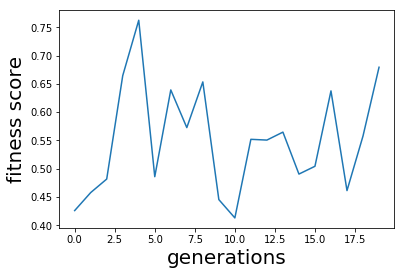

In [5]:
#Best_model = {{'nb_neurons': 128, 'nb_layers': 2, 'activation': 'relu', 'optimizer': 'rmsprop'}}

x_train, x_test, y_train, y_test = readin()
    
generations = 20  # Number of times to evole the population.
population = 20  # Number of networks in each generation.


nn_param_choices = {'nb_neurons': [16, 32, 64, 128],
                    'nb_layers': [1,2,3,4],
                    'activation': ['relu', 'elu', 'tanh', 'sigmoid'],
                    'optimizer': ['rmsprop', 'adam', 'adagrad','adadelta', 'adamax', 'nadam'],}

fitness_history = generate(generations, population, 
                           nn_param_choices,x_train, y_train, x_test, y_test)
plt.plot(fitness_history)
plt.xlabel("generations",fontsize=20)
plt.ylabel("fitness score",fontsize=20)
plt.show()


In [6]:
print(fitness_history)

[0.4258719794313947, 0.45768723955614926, 0.4816127947697947, 0.6644587252438734, 0.7624837095769441, 0.48578078140625225, 0.6392499202405036, 0.5726122807233229, 0.6534126149881299, 0.44529089192676885, 0.41288924959808354, 0.5518925580669019, 0.5505432498271278, 0.5646146697568057, 0.4904267749075578, 0.5042088027675553, 0.6375357852047142, 0.4612041074045659, 0.557754291857626, 0.67935844760068]


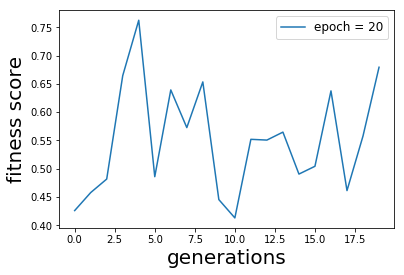

In [7]:
import matplotlib.pyplot as plt
plt.plot(fitness_history)
plt.xlabel("generations",fontsize=20)
plt.ylabel("fitness score",fontsize=20)
plt.legend(['epoch = 20'],fontsize=12)
plt.show()